In [63]:
# notebook for Hi-C data analysis

# Выполнить следующие действия/ответить на вопросы
a.	получить информацию и атрибуты матрицы Hi-C с помощью cooler.info\
b.	открыть объект cooler как сбалансированную матрицу для внутрихромосомных контактов\
c.	получить таблицу с координатами и контактами, они сбалансированные или нет?\
d.	получить таблицу в командной строке командой *cooler dump*\
e.	посмотрите таблицу с бинами, какие столбцы там присутствуют?\
f.	постройте кривые зависимости число контактов от расстояния для выбранной хромосомы (в логарифмических-координатах) для 4х реплик. Сравните их.\
g.	для выбранного участка найдите insulation score и границы тадов для всех реплик \
h.	сравните результаты и постройте графики полученных кривых. Отобразите на них границы  ТАДов.\
i.	Создайте 4 bed файла с границами ТАДов.В поле score добавьте силу границы.\

Хромосома chr2L, участок длиной 1.5 мб: chr2L:1,000,000-2,500,000


In [64]:
import cooler

In [65]:
resolution = 20000
region = 'chr2L:1000000-2500000'
clr = cooler.Cooler(f'hic/HiC1.dm3.mapq_30.1000.mcool::/resolutions/{resolution}')

In [66]:
# получить информацию и атрибуты матрицы Hi-C с помощью cooler.info
clr.info

{'bin-size': 20000,
 'bin-type': 'fixed',
 'creation-date': '2023-04-06T04:39:00.281457',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 6024,
 'nchroms': 7,
 'nnz': 7122786,
 'storage-mode': 'symmetric-upper',
 'sum': 63912926}

In [67]:
# открыть объект cooler как сбалансированную матрицу для внутрихромосомных контактов
balanced = clr.matrix(balance=True).fetch("chr2L")

In [68]:
balanced

array([[9.68142023e-01, 9.40535627e-02, 4.77885096e-02, ...,
        5.17570575e-04,            nan,            nan],
       [9.40535627e-02, 9.88298164e-01, 2.19997929e-01, ...,
        0.00000000e+00,            nan,            nan],
       [4.77885096e-02, 2.19997929e-01, 1.26990154e+00, ...,
        2.86009344e-04,            nan,            nan],
       ...,
       [5.17570575e-04, 0.00000000e+00, 2.86009344e-04, ...,
        1.36600131e+00,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [83]:
# получить таблицу с координатами и контактами, они сбалансированные или нет?
# они не сбалансированные
pixels = clr.pixels()[:]
pixels

,bin1_id,bin2_id,count
0,0,0,1
1,2,2,58
2,2,3,111
3,2,4,30
4,2,5,16
...,...,...,...
5689698,6020,6022,41
5689699,6021,6021,1872
5689700,6021,6022,39
5689701,6022,6022,207


In [70]:
import pandas as pd
pixels_df = pd.DataFrame(pixels)

In [71]:
bins = clr.bins()[:]
bins_df = pd.DataFrame(bins)

In [72]:
# объединим таблицы, чтобы получить таблицу с координатами и контактами
merged_df = pixels_df.merge(bins_df, left_on='bin1_id', right_index=True).merge(bins_df, left_on='bin2_id', right_index=True, suffixes=('_bin1', '_bin2'))
merged_df.head()

,bin1_id,bin2_id,count,chrom_bin1,start_bin1,end_bin1,weight_bin1,chrom_bin2,start_bin2,end_bin2,weight_bin2
0,0,0,4075,chr2L,0,20000,0.015414,chr2L,0,20000,0.015414
1,0,1,481,chr2L,0,20000,0.015414,chr2L,20000,40000,0.012686
2,0,2,182,chr2L,0,20000,0.015414,chr2L,40000,60000,0.017035
3,0,3,183,chr2L,0,20000,0.015414,chr2L,60000,80000,0.010652
4,0,4,84,chr2L,0,20000,0.015414,chr2L,80000,100000,0.010251


In [73]:
# получить таблицу в командной строке командой cooler dump
!cooler dump "hic/HiC1.dm3.mapq_30.1000.mcool::/resolutions/20000" > hic/hic.dump

In [74]:
# посмотрите таблицу с бинами, какие столбцы там присутствуют?
# Там присутствуют столбцы: bin1_id, bin2_id, count

In [75]:
# постройте кривые зависимости число контактов от расстояния для выбранной хромосомы (в логарифмических-координатах) для 4х реплик. Сравните их.

In [76]:
import cooler
import cooltools
import bioframe
import numpy as np
import matplotlib.pyplot as plt

replica_files = [
    f'hic/HiC1.dm3.mapq_30.1000.mcool::/resolutions/{resolution}',
    f'hic/HiC2.dm3.mapq_30.1000.mcool::/resolutions/{resolution}',
    f'hic/HiC3.dm3.mapq_30.1000.mcool::/resolutions/{resolution}',
    f'hic/HiC4.dm3.mapq_30.1000.mcool::/resolutions/{resolution}'
]

# Load the cooler files for each replica
clr_replicas = [cooler.Cooler(replica) for replica in replica_files]

# Fetch chromosome sizes for dm3 from UCSC
dm3_chromsizes = bioframe.fetch_chromsizes('dm3')

# Create a dataframe for chromosome arms without centromeres
dm3_arms = bioframe.make_viewframe(dm3_chromsizes)

# Filter for the chromosomes available in the cooler files
dm3_arms = dm3_arms[dm3_arms.chrom.isin(clr_replicas[0].chromnames)].reset_index(drop=True)

In [77]:
# Specify the chromosome of interest
specific_chromosome = 'chr2L'  # Change this to the chromosome you're interested in

# Filter the regions for the specific chromosome
specific_chrom_arms = dm3_arms[dm3_arms['chrom'] == specific_chromosome]

# Calculate contacts vs distance (P(s)) for the specific chromosome in all replicas
cvd_replicas = []
for clr in clr_replicas:
    cvd_specific_chrom = cooltools.expected_cis(
        clr=clr,
        view_df=specific_chrom_arms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=1  # Set to 1 if you do not have multiple cores available
    )
    cvd_replicas.append(cvd_specific_chrom)


INFO:root:fallback to serial implementation.
/mnt/data/conda/testing/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
INFO:root:fallback to serial implementation.
/mnt/data/conda/testing/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
INFO:root:fallback to serial implementation.
/mnt/data/conda/testing/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: Th

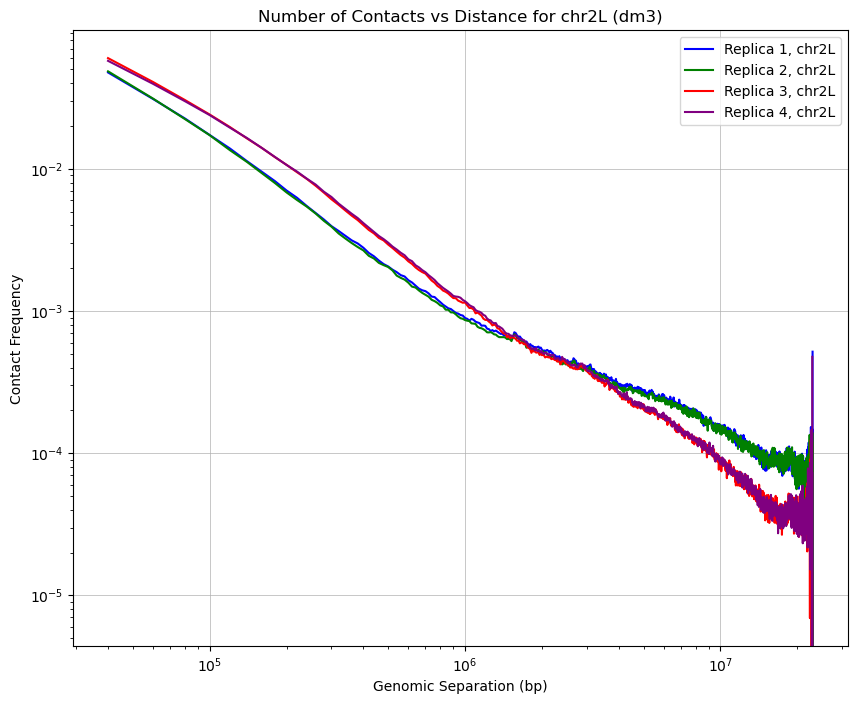

In [78]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']  # Colors for different replicas

for i, cvd_specific_chrom in enumerate(cvd_replicas):
    for region in specific_chrom_arms['name']:
        ax.loglog(
            cvd_specific_chrom['dist_bp'].loc[cvd_specific_chrom['region1'] == region],
            cvd_specific_chrom['contact_frequency'].loc[cvd_specific_chrom['region1'] == region],
            label=f'Replica {i+1}, {region}',
            color=colors[i]
        )

ax.set(
    xlabel='Genomic Separation (bp)',
    ylabel='Contact Frequency',
    title=f'Number of Contacts vs Distance for {specific_chromosome} (dm3)'
)
ax.legend()
ax.grid(lw=0.5)
plt.show()


In [79]:
# реплики 1 и 2 имеют схожие кривые, реплики 3 и 4 имеют схожие кривые

In [80]:
# для выбранного участка найдите insulation score и границы тадов для всех реплик

INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Processing region chr3R
INFO:root:Processing region chr4
INFO:root:Processing region chrX
INFO:root:Processing region chrM
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Processing region chr3R
INFO:root:Processing region chr4
INFO:root:Processing region chrX
INFO:root:Processing region chrM
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Processing region chr3R
INFO:root:Processing region chr4
INFO:root:Processing region chrX
INFO:root:Processing region chrM
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Pro

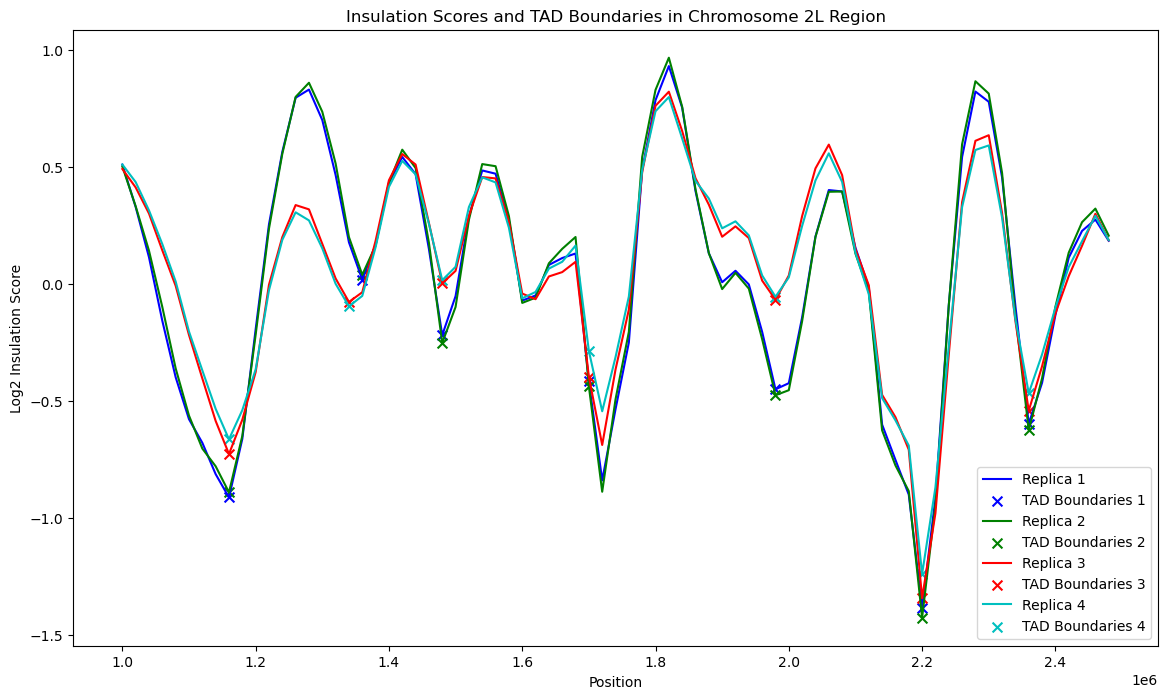

In [81]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cooler
from cooltools import insulation
import bioframe

# Define the region on chromosome 2L
region = ('chr2L', 1000000, 2500000)  # Example region, adjust as needed

# Define window size for insulation score calculation
window = 5 * 20000  # Single window size (adjust as needed)

# Load Hi-C data and calculate insulation scores for each replica
insulation_tables = []
for file in replica_files:
    clr = cooler.Cooler(file)
    ins_table = insulation(clr, [window], verbose=True)
    insulation_tables.append(ins_table)

# Select the region of interest and plot insulation scores and TAD boundaries for each replica
plt.figure(figsize=(14, 8))
colors = ['b', 'g', 'r', 'c']

for idx, (ins_table, color) in enumerate(zip(insulation_tables, colors)):
    insul_region = bioframe.select(ins_table, region)
    
    # Plot insulation scores
    plt.plot(insul_region['start'], insul_region[f'log2_insulation_score_{window}'], label=f'Replica {idx+1}', color=color)
    
    # Identify TAD boundaries
    threshold = np.percentile(insul_region[f'boundary_strength_{window}'].dropna(), 20)
    strong_boundaries = insul_region[insul_region[f'boundary_strength_{window}'] >= threshold]
    
    # Save boundaries to BED file
    bed_data = strong_boundaries[['chrom', 'start', 'end']].copy()
    bed_data['score'] = strong_boundaries[f'boundary_strength_{window}']
    bed_data.to_csv(f'tmp/replica_{idx+1}_boundaries.bed', sep='\t', header=False, index=False)
    
    # Plot TAD boundaries
    plt.scatter(strong_boundaries['start'], strong_boundaries[f'log2_insulation_score_{window}'], color=color, marker='x', s=50, label=f'TAD Boundaries {idx+1}')

plt.xlabel('Position')
plt.ylabel('Log2 Insulation Score')
plt.title('Insulation Scores and TAD Boundaries in Chromosome 2L Region')
plt.legend()
plt.show()
